In [15]:
from estival.model import BayesianCompartmentalModel
import estival.priors as esp
import estival.targets as est
import numpy as np
from estival.wrappers import pymc as epm
import pymc as pm
from tbdynamics.utils import round_sigfig
from tbdynamics.model import build_model
from tbdynamics.inputs import load_params, load_targets, matrix
from tbdynamics.constants import (
    age_strata,
    compartments,
    latent_compartments,
    infectious_compartments,
)
from tbdynamics.plotting import plot_model_vs_actual
import arviz as az

In [2]:
fixed_params = load_params()
tb_model = build_model(
        compartments,
        latent_compartments,
        infectious_compartments,
        age_strata,
        fixed_params,
        matrix,
    )

params = {}
priors = [
        esp.UniformPrior("start_population_size", (2000000.0, 2500000.0)),
        esp.UniformPrior("contact_rate", (0.005, 0.008)),
        esp.UniformPrior("rr_infection_latent", (0.2, 0.5)),
        esp.UniformPrior("rr_infection_recovered", (0.2, 0.5)),
        esp.UniformPrior("progression_multiplier", (1.5, 2.0)),
        esp.UniformPrior("seed_time", (1800.0, 1840.0)),
        esp.UniformPrior("seed_num", (1.0, 100.00)),
        esp.UniformPrior("seed_duration", (1.0, 20.0)),
        esp.UniformPrior("smear_positive_death_rate", (0.335, 0.449)),
        esp.UniformPrior("smear_negative_death_rate", (0.017, 0.035)),
        esp.UniformPrior("smear_positive_self_recovery", (0.177, 0.288)),
        esp.UniformPrior("smear_negative_self_recovery", (0.073, 0.209)),
        esp.UniformPrior("screening_scaleup_shape", (0.05, 0.15)),
        esp.UniformPrior("screening_inflection_time", (1990, 2010)),
        esp.UniformPrior("screening_end_asymp", (0.55, 0.7)),
        esp.UniformPrior("detection_reduction", (0.7, 0.9)),
    ]
target_data = load_targets()
targets = [
        est.NormalTarget("total_population", target_data["total_population"], stdev=10000.0),
        # est.NormalTarget("incidence", target_data["incidence"], 1.0),
        est.NormalTarget("notification", target_data["notification"], stdev=10.0),
        # est.NormalTarget("percentage_latent", target_data["percentage_latent"], 1.0),
        # est.NormalTarget("prevalence_pulmonary", target_data["prevalence_pulmonary"], 1.0),
        #est.NormalTarget("cdr", target_data["cdr"], 0.1)
    ]

bcm =BayesianCompartmentalModel(tb_model, params, priors, targets)

In [3]:
with pm.Model() as pmc_model:
    start_params = {k: np.clip(v, *bcm.priors[k].bounds(0.99)) for k, v in params.items() if k in bcm.priors}
    variables = epm.use_model(bcm)
    map_params = pm.find_MAP(start=start_params, vars=variables, include_transformed=False, maxeval=500)
    map_params = {k: float(v) for k, v in map_params.items()}
print('Best candidate parameters found:')
for i_param, param in enumerate([p for p in map_params if '_dispersion' not in p]):
    print(f'   {param}: {round_sigfig(map_params[param], 4)} (within bound {priors[i_param].bounds()}')
print(map_params)
params.update(map_params)
tb_model.run(parameters=params)

Output()

Best candidate parameters found:
   start_population_size: 2000000.0 (within bound (2000000.0, 2500000.0)
   contact_rate: 0.008 (within bound (0.005, 0.008)
   rr_infection_latent: 0.467 (within bound (0.2, 0.5)
   rr_infection_recovered: 0.2211 (within bound (0.2, 0.5)
   progression_multiplier: 1.657 (within bound (1.5, 2.0)
   seed_time: 1815.0 (within bound (1800.0, 1840.0)
   seed_num: 50.79 (within bound (1.0, 100.0)
   seed_duration: 10.5 (within bound (1.0, 20.0)
   smear_positive_death_rate: 0.386 (within bound (0.335, 0.449)
   smear_negative_death_rate: 0.02521 (within bound (0.017, 0.035)
   smear_positive_self_recovery: 0.2327 (within bound (0.177, 0.288)
   smear_negative_self_recovery: 0.1422 (within bound (0.073, 0.20900000000000002)
   screening_scaleup_shape: 0.05577 (within bound (0.05, 0.15)
   screening_inflection_time: 2002.0 (within bound (1990.0, 2010.0)
   screening_end_asymp: 0.55 (within bound (0.55, 0.7)
   detection_reduction: 0.7662 (within bound (0.7, 0.

In [4]:
derived_df_0 = tb_model.get_derived_outputs_df()

In [ ]:
plot_model_vs_actual(
    derived_df_0, target_data['total_population'], "total_population", "Population", "Modelled vs Data"
)

In [ ]:
plot_model_vs_actual(
    derived_df_0, target_data['percentage_latent'], "percentage_latent", "Percentage latent", "Modelled vs Data"
)

In [ ]:
plot_model_vs_actual(derived_df_0, target_data['prevalence_pulmonary'], 'prevalence_pulmonary', 'Infectious prevalence', 'Modelled vs Estimation from 2017 prevalence survey')

In [8]:
plot_model_vs_actual(
    derived_df_0, target_data['incidence'], "incidence", "Incidence", "Modelled vs Data"
)

In [9]:
plot_model_vs_actual(
    derived_df_0, target_data['notification'], "notification", "Notifications", "Modelled vs Data"
)

In [10]:
nparams = {
    "start_population_size": 2000000.000000584,
    # "contact_rate": 0.00799998496434649,
    "rr_infection_latent": 0.4685598987988698,
    "rr_infection_recovered": 0.20745664581278986,
    "progression_multiplier": 1.6720167708499327,
    "seed_time": 1814.8853385094426,
    "seed_num": 50.64888812259932,
    "seed_duration": 10.491361094180998,
    "smear_positive_death_rate": 0.38654199531405087,
    "smear_negative_death_rate": 0.025755845817440722,
    "smear_positive_self_recovery": 0.23321635702709886,
    "smear_negative_self_recovery": 0.1421912984237043,
    "screening_scaleup_shape": 0.05000000000000329,
    "screening_inflection_time": 2003.1965223765128,
    "screening_end_asymp": 0.550000000000232,
    "detection_reduction": 0.7594960084213216,
}
npriors = [
        # esp.UniformPrior("start_population_size", (2000000.0, 2500000.0)),
        esp.UniformPrior("contact_rate", (0.005, 0.008)),
        # esp.UniformPrior("rr_infection_latent", (0.2, 0.5)),
        # esp.UniformPrior("rr_infection_recovered", (0.2, 0.5)),
        # esp.UniformPrior("progression_multiplier", (1.5, 2.0)),
        # esp.UniformPrior("seed_time", (1800.0, 1840.0)),
        # esp.UniformPrior("seed_num", (1.0, 100.00)),
        # esp.UniformPrior("seed_duration", (1.0, 20.0)),
        # esp.UniformPrior("smear_positive_death_rate", (0.335, 0.449)),
        # esp.UniformPrior("smear_negative_death_rate", (0.017, 0.035)),
        # esp.UniformPrior("smear_positive_self_recovery", (0.177, 0.288)),
        # esp.UniformPrior("smear_negative_self_recovery", (0.073, 0.209)),
        # esp.UniformPrior("screening_scaleup_shape", (0.05, 0.15)),
        # esp.UniformPrior("screening_inflection_time", (1990, 2010)),
        # esp.UniformPrior("screening_end_asymp", (0.55, 0.7)),
        # esp.UniformPrior("detection_reduction", (0.7, 0.9)),
    ]

In [11]:
nbcm = BayesianCompartmentalModel(tb_model, nparams, npriors, targets)

In [13]:
with pm.Model() as model:
    variables = epm.use_model(nbcm)
    idata = pm.sample(step=[pm.DEMetropolis(variables)],draws=20000, tune=5000)

Population sampling (4 chains)
DEMetropolis: [contact_rate]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Output()

Population parallelization failed. Falling back to sequential stepping of chains.


Output()

c:\Users\vbui0010\Anaconda3\envs\tbdyn\lib\site-packages\pymc\step_methods\metropolis.py:844: RuntimeWarning:

overflow encountered in exp

Sampling 4 chains for 5_000 tune and 20_000 draw iterations (20_000 + 80_000 draws total) took 5863 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<AxesSubplot: title={'center': 'contact_rate'}>,
        <AxesSubplot: title={'center': 'contact_rate'}>]], dtype=object)

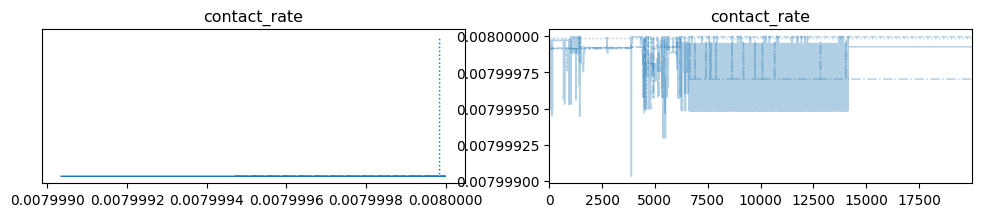

In [16]:
az.plot_trace(idata)

In [17]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
contact_rate,0.008,0.0,0.008,0.008,0.0,0.0,6.0,24.0,1.68
